In [1]:
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import label_binarize
import tensorflow as tf
%matplotlib inline

C:\Users\Amir\anaconda3\envs\tensorflow\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
glioma=r"D:\Irfan\Kaggle\Brain Tumor\brain tumor dataset\Training\glioma"
image_size=[150,150]
train_data=r"D:\Irfan\kaggle\brain tumor\brain tumor dataset\Training"
test_data=r"D:\Irfan\kaggle\brain tumor\brain tumor dataset\Testing"
valid_data=r"D:\Irfan\kaggle\brain tumor\brain tumor dataset\Testing"

In [5]:
filepath=[]
label=[]
image_folder=os.listdir(train_data)
for folder in image_folder:
    folder_path=os.path.join(train_data,folder)
    filelist=os.listdir(folder_path)
    for file in filelist:
        new_path=os.path.join(folder_path,file)
        filepath.append(new_path)
        label.append(folder)
        

image_data=pd.Series(filepath,name="image_data")
label_data=pd.Series(label,name="label")
train_df=pd.concat([image_data,label_data],axis=1)


In [6]:
filepath=[]
label=[]
image_folder=os.listdir(test_data)
for folder in image_folder:
    folder_path=os.path.join(test_data,folder)
    filelist=os.listdir(folder_path)
    for file in filelist:
        new_path=os.path.join(folder_path,file)
        filepath.append(new_path)
        label.append(folder)
        

image_data=pd.Series(filepath,name="image_data")
label_data=pd.Series(label,name="label")
test_df=pd.concat([image_data,label_data],axis=1)

In [7]:
filepath=[]
label=[]
image_folder=os.listdir(valid_data)
for folder in image_folder:
    folder_path=os.path.join(valid_data,folder)
    filelist=os.listdir(folder_path)
    for file in filelist:
        new_path=os.path.join(folder_path,file)
        filepath.append(new_path)
        label.append(folder)
        

image_data=pd.Series(filepath,name="image_data")
label_data=pd.Series(label,name="label")
valid_df=pd.concat([image_data,label_data],axis=1)


In [8]:
batch_size=16
color_channel=3
image_shape=(150,150,3)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_generator=ImageDataGenerator(rescale=1./255)

train_data_generator=train_generator.flow_from_dataframe(train_df,x_col="image_data",y_col="label",
                                                        target_size=image_size,
                                                        color_mode="rgb",
                                                        shuffle=True,
                                                        batch_size=batch_size)

test_data_generator=test_generator.flow_from_dataframe(test_df,x_col="image_data",y_col="label",
                                                        target_size=image_size,
                                                        color_mode="rgb",
                                                        shuffle=False,
                                                        batch_size=batch_size)

valid_data_generator=test_generator.flow_from_dataframe(valid_df,x_col="image_data",y_col="label",
                                                        target_size=image_size,
                                                        color_mode="rgb",
                                                        shuffle=True,
                                                        batch_size=batch_size)


Found 5712 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [9]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


batch_size = 16
image_shape = (150, 150, 3)

# Function to create DenseNet-169 model
def create_densenet169_model(input_shape, num_classes):
    base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    return model

num_classes = len(train_data_generator.class_indices)


model = create_densenet169_model(image_shape, num_classes)


model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()


51877672/51877672 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 75, 75, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization

                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 38, 38, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 38, 38, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 38, 38, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 38, 38, 32)   36864       ['conv2_block4_1_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 19, 19, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 19, 19, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 19, 19, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

 conv3_block6_1_relu (Activatio  (None, 19, 19, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 19, 19, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 19, 19, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 19, 19, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 19, 19, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 19, 19, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 19, 19, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 19, 19, 128)  512        ['conv3_block11_1_conv[0][0]']   
 lization)

 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 9, 9, 320)   1280        ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 9, 9, 320)   0           ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 9, 9, 128)    40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 9, 9, 128)    57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 9, 9, 128)   512         ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 9, 9, 128)   0           ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 9, 9, 32)     36864       ['conv4_block7_1_relu[0][0]']    
          

 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 9, 9, 32)     36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 9, 9, 608)   0           ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 9, 9, 608)   2432        ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block16_0_bn (BatchNorma  (None, 9, 9, 736)   2944        ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 9, 9, 736)   0           ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 9, 9, 128)    94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 9, 9, 128)   512         ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 9, 9, 128)   512         ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 9, 9, 128)   0           ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 9, 9, 32)     36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 9, 9, 896)   0           ['conv4_block19_concat[0][0]',   
 ate)     

 conv4_block24_2_conv (Conv2D)  (None, 9, 9, 32)     36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 9, 9, 1024)  0           ['conv4_block23_concat[0][0]',   
 ate)                                                             'conv4_block24_2_conv[0][0]']   
                                                                                                  
 conv4_block25_0_bn (BatchNorma  (None, 9, 9, 1024)  4096        ['conv4_block24_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block25_0_relu (Activati  (None, 9, 9, 1024)  0           ['conv4_block25_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block29_0_relu (Activati  (None, 9, 9, 1152)  0           ['conv4_block29_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block29_1_conv (Conv2D)  (None, 9, 9, 128)    147456      ['conv4_block29_0_relu[0][0]']   
                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, 9, 9, 128)   512         ['conv4_block29_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block29_1_relu (Activati  (None, 9, 9, 128)   0           ['conv4_block29_1_bn[0][0]']     
 on)      

 ization)                                                                                         
                                                                                                  
 conv5_block1_0_relu (Activatio  (None, 4, 4, 640)   0           ['conv5_block1_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_1_conv (Conv2D)   (None, 4, 4, 128)    81920       ['conv5_block1_0_relu[0][0]']    
                                                                                                  
 conv5_block1_1_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv5_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_blo

 conv5_block5_1_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv5_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block5_1_relu (Activatio  (None, 4, 4, 128)   0           ['conv5_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block5_2_conv (Conv2D)   (None, 4, 4, 32)     36864       ['conv5_block5_1_relu[0][0]']    
                                                                                                  
 conv5_block5_concat (Concatena  (None, 4, 4, 800)   0           ['conv5_block4_concat[0][0]',    
 te)                                                              'conv5_block5_2_conv[0][0]']    
          

                                                                                                  
 conv5_block9_concat (Concatena  (None, 4, 4, 928)   0           ['conv5_block8_concat[0][0]',    
 te)                                                              'conv5_block9_2_conv[0][0]']    
                                                                                                  
 conv5_block10_0_bn (BatchNorma  (None, 4, 4, 928)   3712        ['conv5_block9_concat[0][0]']    
 lization)                                                                                        
                                                                                                  
 conv5_block10_0_relu (Activati  (None, 4, 4, 928)   0           ['conv5_block10_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_blo

 conv5_block14_0_relu (Activati  (None, 4, 4, 1056)  0           ['conv5_block14_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block14_1_conv (Conv2D)  (None, 4, 4, 128)    135168      ['conv5_block14_0_relu[0][0]']   
                                                                                                  
 conv5_block14_1_bn (BatchNorma  (None, 4, 4, 128)   512         ['conv5_block14_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block14_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block14_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv5_block18_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block18_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block18_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block18_1_relu[0][0]']   
                                                                                                  
 conv5_block18_concat (Concaten  (None, 4, 4, 1216)  0           ['conv5_block17_concat[0][0]',   
 ate)                                                             'conv5_block18_2_conv[0][0]']   
                                                                                                  
 conv5_block19_0_bn (BatchNorma  (None, 4, 4, 1216)  4864        ['conv5_block18_concat[0][0]']   
 lization)

 ate)                                                             'conv5_block22_2_conv[0][0]']   
                                                                                                  
 conv5_block23_0_bn (BatchNorma  (None, 4, 4, 1344)  5376        ['conv5_block22_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block23_0_relu (Activati  (None, 4, 4, 1344)  0           ['conv5_block23_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block23_1_conv (Conv2D)  (None, 4, 4, 128)    172032      ['conv5_block23_0_relu[0][0]']   
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block27_1_conv (Conv2D)  (None, 4, 4, 128)    188416      ['conv5_block27_0_relu[0][0]']   
                                                                                                  
 conv5_block27_1_bn (BatchNorma  (None, 4, 4, 128)   512         ['conv5_block27_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block27_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block27_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block27_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block27_1_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv5_block31_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block31_1_relu[0][0]']   
                                                                                                  
 conv5_block31_concat (Concaten  (None, 4, 4, 1632)  0           ['conv5_block30_concat[0][0]',   
 ate)                                                             'conv5_block31_2_conv[0][0]']   
                                                                                                  
 conv5_block32_0_bn (BatchNorma  (None, 4, 4, 1632)  6528        ['conv5_block31_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_blo

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)


history = model.fit(train_data_generator,validation_data=valid_data_generator,epochs=50,
    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
357/357 [==============================] - 26s 72ms/step - loss: 0.1005 - accuracy: 0.9632 - val_loss: 0.1723 - val_accuracy: 0.9359 - lr: 2.0000e-04
Epoch 2/50
357/357 [==============================] - 25s 70ms/step - loss: 0.0832 - accuracy: 0.9695 - val_loss: 0.1345 - val_accuracy: 0.9558 - lr: 2.0000e-04
Epoch 3/50
357/357 [==============================] - 25s 70ms/step - loss: 0.0844 - accuracy: 0.9690 - val_loss: 0.1278 - val_accuracy: 0.9535 - lr: 2.0000e-04
Epoch 4/50
357/357 [==============================] - 24s 68ms/step - loss: 0.0785 - accuracy: 0.9723 - val_loss: 0.1441 - val_accuracy: 0.9466 - lr: 2.0000e-04
Epoch 5/50
357/357 [==============================] - 25s 70ms/step - loss: 0.0757 - accuracy: 0.9715 - val_loss: 0.1171 - val_accuracy: 0.9573 - lr: 2.0000e-04
Epoch 6/50
357/357 [==============================] - 24s 68ms/step - loss: 0.0758 - accuracy: 0.9727 - val_loss: 0.1298 - val_accuracy: 0.9489 - lr: 2.0000e-04
Epoch 7/50
357/357 [==============

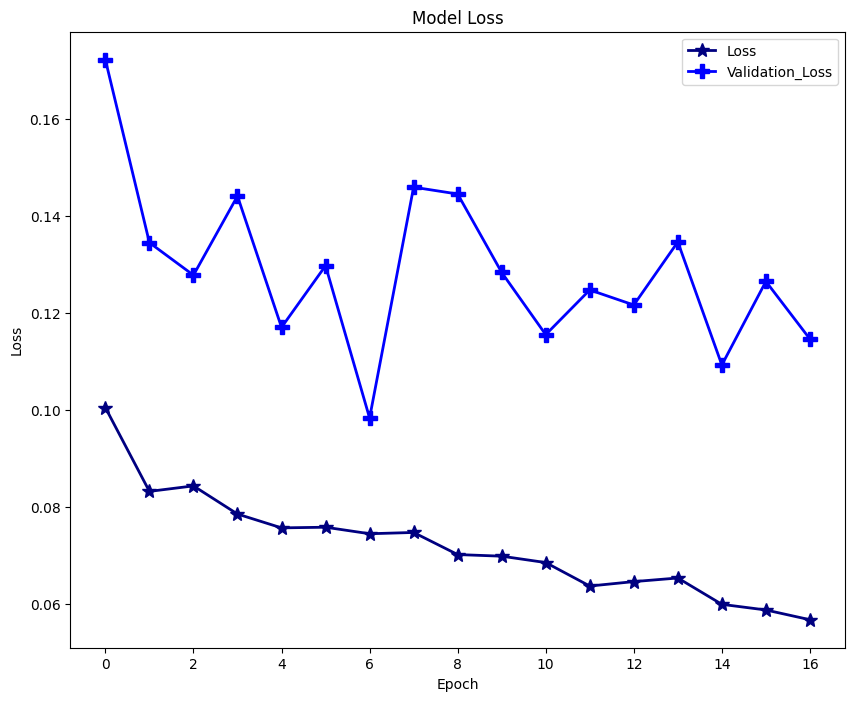

In [12]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'],lw=2,marker="*",markersize=10,color="navy",label="Loss")
plt.plot(history.history['val_loss'],lw=2,marker="P",markersize=10,color="blue",label="Validation_Loss")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.show()

In [13]:
model.save('brain_tumor_classifier.h5')


In [14]:
label_name=["glioma","meningioma","notumor","pituitary"]


In [15]:
pred=model.predict(test_data_generator)
final=np.argmax(pred,axis=1)

82/82 [==============================] - 4s 32ms/step


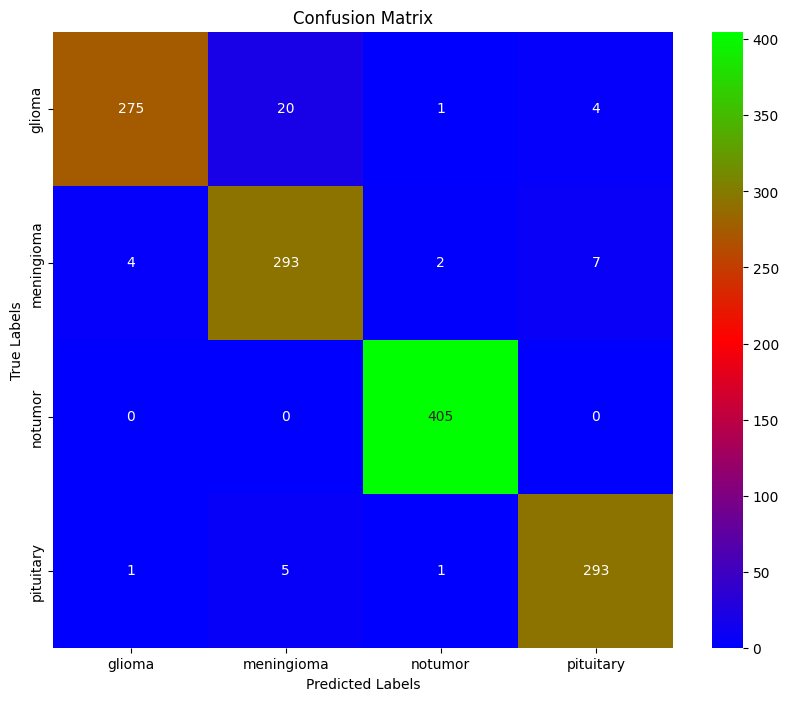

In [16]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import log_loss, cohen_kappa_score, matthews_corrcoef, brier_score_loss,accuracy_score

true_data=test_data_generator.classes
cf=confusion_matrix(test_data_generator.classes,final)
plt.figure(figsize=(10,8))

sns.heatmap(cf, annot=True, cmap='brg', fmt='g',xticklabels=label_name,yticklabels=label_name)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show()

In [36]:
img_having_error=r"D:\Irfan\kaggle\brain tumor\brain tumor dataset\Testing\meningioma\Te-me_0180.jpg"
img_working=r"D:\Irfan\kaggle\brain tumor\brain tumor dataset\Testing\meningioma\Te-me_0019.jpg"


In [25]:
from PIL import Image


In [37]:
image = Image.open(img_working)
       

In [38]:
image.size

(300, 345)

In [40]:
image = image.resize((150, 150))
image = np.array(image)
image = image / 255.0  # Normalize to [0, 1]
image = np.expand_dims(image, axis=0)  # Add batch dimension

In [41]:
image.shape

(1, 150, 150, 3)

In [42]:
predictions = model.predict_prob(image)

AttributeError: 'Functional' object has no attribute 'predict_prob'